In [3]:
import matplotlib.patches as patches
from xml.etree import ElementTree
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import cv2

In [2]:
xml_file_path = (
    "/content/drive/MyDrive/Wildfire Dataset/train/ck0k99e6p79go0944lmxivkmv_jpeg.rf.035851b1218826a8d8e1f6cff055da7a.xml"
)


def read_xml_file(file_path):
    with open(file_path, "r") as file:
        data = file.read()
    return data


xml_content = read_xml_file(xml_file_path)
print(xml_content)

<annotation>
	<folder />
	<filename>ck0k99e6p79go0944lmxivkmv_jpeg.rf.035851b1218826a8d8e1f6cff055da7a.jpg</filename>
	<path>ck0k99e6p79go0944lmxivkmv_jpeg.rf.035851b1218826a8d8e1f6cff055da7a.jpg</path>
	<source>
		<database>roboflow.ai</database>
	</source>
	<size>
		<width>640</width>
		<height>480</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>smoke</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<occluded>0</occluded>
		<bndbox>
			<xmin>448</xmin>
			<xmax>539</xmax>
			<ymin>196</ymin>
			<ymax>241</ymax>
		</bndbox>
	</object>
</annotation>


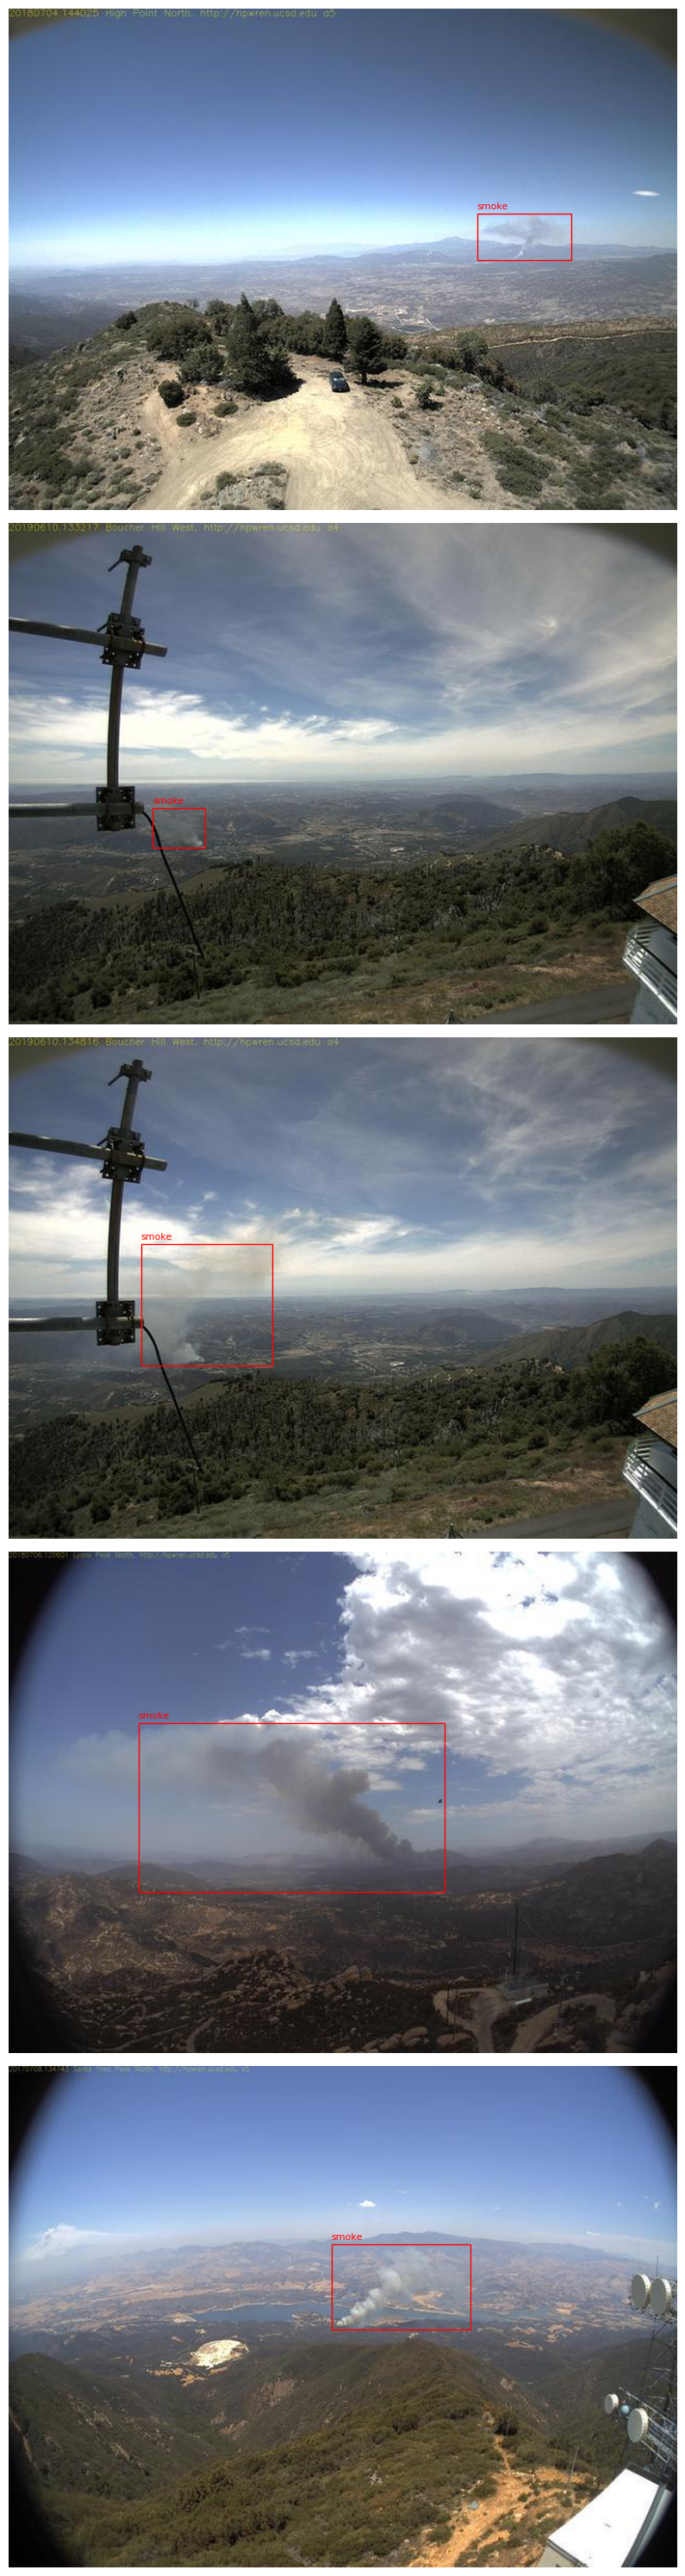

In [11]:
data_dir = "/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/train"

files = os.listdir(data_dir)
files.sort()
image_files = [file for file in files if file.endswith(".jpg")]
xml_files = [file for file in files if file.endswith(".xml")]

def resize_image_and_annotations(image, annotations, short_side_length=600):
    scale = short_side_length / min(image.size)
    new_size = (int(scale * image.size[0]), int(scale * image.size[1]))

    resized_image = image.resize(new_size, Image.LANCZOS)

    scaled_annotations = []
    for ann in annotations:
        scaled_ann = {
            "label": ann["label"],
            "xmin": int(ann["xmin"] * scale),
            "ymin": int(ann["ymin"] * scale),
            "xmax": int(ann["xmax"] * scale),
            "ymax": int(ann["ymax"] * scale),
        }
        scaled_annotations.append(scaled_ann)

    return resized_image, scaled_annotations


def get_annotations(xml_file_path):
    """
    Parses an XML file and gets the annotations, returning a list of dictionaries
    with the bounding box details.
    """
    tree = ElementTree.parse(xml_file_path)
    root = tree.getroot()
    annotations = []

    for member in root.findall("object"):
        label = member.find("name").text
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        annotations.append(
            {"label": label, "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax}
        )

    return annotations


resized_images = []
resized_annotations = []

for i in range(5):
    img_path = os.path.join(data_dir, image_files[i])
    image = Image.open(img_path)

    xml_path = os.path.join(data_dir, xml_files[i])
    annotations = get_annotations(xml_path)

    resized_image, scaled_annotations = resize_image_and_annotations(image, annotations)
    resized_images.append(resized_image)
    resized_annotations.append(scaled_annotations)

fig, axes = plt.subplots(
    5, 1, figsize=(12, 30)
)

for ax, img, anns in zip(axes, resized_images, resized_annotations):
    ax.imshow(img)
    ax.axis("off")

    for ann in anns:
        rect = patches.Rectangle(
            (ann["xmin"], ann["ymin"]),
            ann["xmax"] - ann["xmin"],
            ann["ymax"] - ann["ymin"],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(ann["xmin"], ann["ymin"] - 5, ann["label"], color="red", fontsize=8)

plt.tight_layout()
plt.show()

In [24]:
import os
import xml.etree.ElementTree as ET
from PIL import Image


def extract_boxes(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    boxes = []
    for member in root.findall("object"):
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
    return boxes


def rescale_boxes(boxes, orig_size, new_size):
    x_scale = new_size[0] / orig_size[0]
    y_scale = new_size[1] / orig_size[1]
    new_boxes = []
    for box in boxes:
        new_box = [
            int(box[0] * x_scale),
            int(box[1] * y_scale),
            int(box[2] * x_scale),
            int(box[3] * y_scale),
        ]
        new_boxes.append(new_box)
    return new_boxes


# Directory containing the dataset
dataset_dir = "/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/train"
new_size = (640, 480)
file_name_list = []
xmin_list = []
xmax_list = []
ymin_list = []
ymax_list = []
label_list = []

for file in os.listdir(dataset_dir):
    if file.endswith(".jpg") or file.endswith(".jpeg"):
        file_name_list.append(file)
        image_path = os.path.join(dataset_dir, file)
        image = Image.open(image_path)
        orig_size = image.size
        image = image.resize(new_size, Image.LANCZOS)
        image.save(image_path)

        xml_file = os.path.join(dataset_dir, os.path.splitext(file)[0] + ".xml")
        if os.path.exists(xml_file):
            boxes = extract_boxes(xml_file)
            new_boxes = rescale_boxes(boxes, orig_size, new_size)

            tree = ET.parse(xml_file)
            root = tree.getroot()
            for i, member in enumerate(root.findall("object")):
                member.find("bndbox/xmin").text = str(new_boxes[i][0])
                member.find("bndbox/ymin").text = str(new_boxes[i][1])
                member.find("bndbox/xmax").text = str(new_boxes[i][2])
                member.find("bndbox/ymax").text = str(new_boxes[i][3])
                xmin_list.append(float(member.find("bndbox/xmin").text))
                xmax_list.append(float(member.find("bndbox/xmax").text))
                ymin_list.append(float(member.find("bndbox/ymin").text))
                ymax_list.append(float(member.find("bndbox/ymax").text))
                label_list.append(member.find("name").text)
            tree.write(xml_file)

print("Preprocessing train data complete.")

Preprocessing train data complete.


In [17]:
import os
import xml.etree.ElementTree as ET
from PIL import Image


def extract_boxes(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    boxes = []
    for member in root.findall("object"):
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
    return boxes


def rescale_boxes(boxes, orig_size, new_size):
    x_scale = new_size[0] / orig_size[0]
    y_scale = new_size[1] / orig_size[1]
    new_boxes = []
    for box in boxes:
        new_box = [
            int(box[0] * x_scale),  # New xmin
            int(box[1] * y_scale),  # New ymin
            int(box[2] * x_scale),  # New xmax
            int(box[3] * y_scale),  # New ymax
        ]
        new_boxes.append(new_box)
    return new_boxes


dataset_dir = "/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/test"
new_size = (640, 480)
file_name_list = []
xmin_list = []
xmax_list = []
ymin_list = []
ymax_list = []
label_list = []

for file in os.listdir(dataset_dir):
    if file.endswith(".jpg") or file.endswith(".jpeg"):
        file_name_list.append(file)
        image_path = os.path.join(dataset_dir, file)
        image = Image.open(image_path)
        orig_size = image.size
        image = image.resize(new_size, Image.LANCZOS)
        image.save(image_path)

        xml_file = os.path.join(dataset_dir, os.path.splitext(file)[0] + ".xml")
        if os.path.exists(xml_file):
            boxes = extract_boxes(xml_file)
            new_boxes = rescale_boxes(boxes, orig_size, new_size)

            tree = ET.parse(xml_file)
            root = tree.getroot()
            for i, member in enumerate(root.findall("object")):
                member.find("bndbox/xmin").text = str(new_boxes[i][0])
                member.find("bndbox/ymin").text = str(new_boxes[i][1])
                member.find("bndbox/xmax").text = str(new_boxes[i][2])
                member.find("bndbox/ymax").text = str(new_boxes[i][3])
                xmin_list.append(float(member.find("bndbox/xmin").text))
                xmax_list.append(float(member.find("bndbox/xmax").text))
                ymin_list.append(float(member.find("bndbox/ymin").text))
                ymax_list.append(float(member.find("bndbox/ymax").text))
                label_list.append(member.find("name").text)
            tree.write(xml_file)

print("Preprocessing test data complete.")

Preprocessing test data complete.


In [19]:
import os
import xml.etree.ElementTree as ET
from PIL import Image


def extract_boxes(filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    boxes = []
    for member in root.findall("object"):
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])
    return boxes


def rescale_boxes(boxes, orig_size, new_size):
    x_scale = new_size[0] / orig_size[0]
    y_scale = new_size[1] / orig_size[1]
    new_boxes = []
    for box in boxes:
        new_box = [
            int(box[0] * x_scale),
            int(box[1] * y_scale),
            int(box[2] * x_scale),
            int(box[3] * y_scale),
        ]
        new_boxes.append(new_box)
    return new_boxes


dataset_dir = "/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/valid"
new_size = (640, 480)
file_name_list = []
xmin_list = []
xmax_list = []
ymin_list = []
ymax_list = []
label_list = []

for file in os.listdir(dataset_dir):
    if file.endswith(".jpg") or file.endswith(".jpeg"):
        file_name_list.append(file)
        image_path = os.path.join(dataset_dir, file)
        image = Image.open(image_path)
        orig_size = image.size
        image = image.resize(new_size, Image.LANCZOS)
        image.save(image_path)

        xml_file = os.path.join(dataset_dir, os.path.splitext(file)[0] + ".xml")
        if os.path.exists(xml_file):
            boxes = extract_boxes(xml_file)
            new_boxes = rescale_boxes(boxes, orig_size, new_size)

            tree = ET.parse(xml_file)
            root = tree.getroot()
            for i, member in enumerate(root.findall("object")):
                member.find("bndbox/xmin").text = str(new_boxes[i][0])
                member.find("bndbox/ymin").text = str(new_boxes[i][1])
                member.find("bndbox/xmax").text = str(new_boxes[i][2])
                member.find("bndbox/ymax").text = str(new_boxes[i][3])
                xmin_list.append(float(member.find("bndbox/xmin").text))
                xmax_list.append(float(member.find("bndbox/xmax").text))
                ymin_list.append(float(member.find("bndbox/ymin").text))
                ymax_list.append(float(member.find("bndbox/ymax").text))
                label_list.append(member.find("name").text)
            tree.write(xml_file)

print("Preprocessing valid data complete.")

Preprocessing valid data complete.


In [31]:
from torch.nn import Conv2d
import torchvision.models as models
backbone = models.vgg16(pretrained=True).features


def rpn_layer(base_layers, num_anchors=9):

    x = Conv2d(512, (3, 3), padding='same', activation='relu')(base_layers)

    x_class = Conv2d(num_anchors, (1, 1), activation='sigmoid')(x)

    x_regr = Conv2d(num_anchors * 4, (1, 1), activation='linear')(x)

    return [x_class, x_regr, base_layers]

In [8]:
class RoiPoolingConv(Layer):

    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]

        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)


        final_output = K.concatenate(outputs, axis=0)

        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output


    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [10]:
#Classifier layer

def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):


    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    out = Flatten(name='flatten')(out_roi_pool)
    out = Dense(4096, activation='relu', name='fc1')(out)
    out = Dropout(0.5)(out)
    out = Dense(4096, activation='relu', name='fc2')(out)
    out = Dropout(0.5)(out)

    out_class = Dense(nb_classes, activation='softmax', kernel_initializer='zero', name='dense_class_{}'.format(nb_classes))(out)

    out_regr = Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero', name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

In [15]:
import xml.etree.ElementTree as ET

def parse_xml(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    annotations = []

    for member in root.findall('object'):
        bbox = member.find('bndbox')
        annotations.append({
            'label': member.find('name').text,
            'bbox': [
                int(bbox.find('xmin').text),
                int(bbox.find('ymin').text),
                int(bbox.find('xmax').text),
                int(bbox.find('ymax').text)
            ]
        })

    return annotations


In [20]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as transforms

# files = os.listdir(data_dir)
# files.sort()
# image_files = [file for file in files if file.endswith(".jpg")]
# xml_files = [file for file in files if file.endswith(".xml")]

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.files = os.listdir(root)
        self.transform = transform
        self.images = [file for file in self.files if file.endswith(".jpg")]
        self.annotations = [file for file in self.files if file.endswith(".xml")]

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        annot_path = os.path.join(self.root, self.annotations[idx])
        img = Image.open(img_path).convert("RGB")
        annotations = parse_xml(annot_path)

        boxes = []
        labels = []
        for annot in annotations:
            boxes.append(annot['bbox'])
            labels.append(annot['label'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])

        if self.transform:
            img, target = self.transform(img, target)

        return img, target

    def __len__(self):
        return len(self.images)

root = '/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/train'
custom_transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor()
])

dataset = CustomDataset(root=root, transform=custom_transform)


In [21]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)


In [23]:
import torchvision.models as models

backbone = models.vgg16(pretrained=True).features

for param in backbone.parameters():
    param.requires_grad = False


backbone.out_channels = 512

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork

anchor_generator = AnchorGenerator(sizes=((128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

rpn_head = RPNHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0])

rpn = RegionProposalNetwork(
    anchor_generator=anchor_generator,
    head=rpn_head,
    fg_iou_thresh=0.7,
    bg_iou_thresh=0.3,
    batch_size_per_image=256,
    positive_fraction=0.5,
    pre_nms_top_n={'training': 2000, 'testing': 1000},
    post_nms_top_n={'training': 2000, 'testing': 1000},
    nms_thresh=0.7
)

In [28]:
from torchvision.ops import MultiScaleRoIAlign



featmap_names = [0]
output_size = 7


spatial_scale = 1 / 16

box_roi_pool = MultiScaleRoIAlign(featmap_names=featmap_names,
                                  output_size=output_size,
                                  sampling_ratio=2)



In [ ]:
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torch.utils.data import DataLoader

in_features = 4096
num_classes = 2
train_dataset = CustomDataset(root=root, transform=custom_transform)
fast_rcnn_predictor = FastRCNNPredictor(in_features, num_classes)

model = FasterRCNN(backbone=backbone,
                  #  num_classes=num_classes,
                   rpn=rpn,
                   box_roi_pool=box_roi_pool,
                   box_predictor=fast_rcnn_predictor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 10

model.train()
for epoch in range(num_epochs):
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.ops import MultiScaleRoIAlign
import torchvision.models as models
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torch import nn

def vgg_fpn_backbone(backbone_name, pretrained):
    model = models.__dict__[backbone_name](pretrained=pretrained)
    backbone = model.features

    return_layers = {'5': '0', '10': '1', '17': '2', '24': '3', '31': 'pool'}

    in_channels_list = [64, 128, 256, 512, 512]

    out_channels = 256

    for name, module in backbone.named_children():
        if name in return_layers:
            return_layers[name] = return_layers[name]
        else:
            return_layers[name] = None

    backbone_with_fpn = BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels)
    return backbone_with_fpn

backbone_with_fpn = vgg_fpn_backbone('vgg16', pretrained=True)

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=7, sampling_ratio=2)


num_classes = 2

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
in_features = backbone_with_fpn.out_channels
box_predictor = FastRCNNPredictor(in_features, num_classes)

model = FasterRCNN(backbone_with_fpn,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler,
                   box_predictor=box_predictor)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [3]:
target

{'boxes': tensor([[199., 207., 219., 229.]]),
 'labels': tensor([1]),
 'image_id': tensor([0])}

In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import MultiScaleRoIAlign
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models

In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.transforms as transforms

class FireDetectionDataset(Dataset):
    def __init__(self, train_dir, transform=None):
        self.train_dir = train_dir
        self.transform = transform
        self.images = [f for f in os.listdir(train_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Image
        img_name = self.images[index]
        img_path = os.path.join(self.train_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # Annotation
        annot_name = os.path.splitext(img_name)[0] + '.xml'
        annot_path = os.path.join(self.train_dir, annot_name)
        boxes = []
        labels = []

        tree = ET.parse(annot_path)
        root = tree.getroot()

        for member in root.findall('object'):
            labels.append(1)

            xmin = int(member.find('bndbox/xmin').text)
            ymin = int(member.find('bndbox/ymin').text)
            xmax = int(member.find('bndbox/xmax').text)
            ymax = int(member.find('bndbox/ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([index])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        if self.transform:
            image = self.transform(image)

        return image, target



In [4]:

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dir = "/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/train"
val_dir = '/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/valid'
test_dir = '/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/test'

train_dataset = FireDetectionDataset(train_dir, transform=transform)
val_dataset = FireDetectionDataset(val_dir, transform=transform)
test_dataset = FireDetectionDataset(test_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
image, target = train_dataset[0]


In [15]:
class BasicRPN(nn.Module):
    def __init__(self, in_channels):
        super(BasicRPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)
        self.cls_logits = nn.Conv2d(512, 9 * 2, kernel_size=1)
        self.bbox_pred = nn.Conv2d(512, 9 * 4, kernel_size=1)

        anchor_sizes = ((128, 256, 512),)
        aspect_ratios = ((0.5, 1.0, 2.0),)

        self.anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

        torch.nn.init.normal_(self.conv.weight, std=0.01)
        torch.nn.init.normal_(self.cls_logits.weight, std=0.01)
        torch.nn.init.normal_(self.bbox_pred.weight, std=0.01)
        torch.nn.init.constant_(self.conv.bias, 0)
        torch.nn.init.constant_(self.cls_logits.bias, 0)
        torch.nn.init.constant_(self.bbox_pred.bias, 0)

    def forward(self, x):
        x = F.relu(self.conv(x))
        logits = self.cls_logits(x)
        bbox_reg = self.bbox_pred(x)
        return logits, bbox_reg


In [16]:
def create_vgg_backbone(pretrained=True):
    vgg = models.vgg16(pretrained=pretrained).features
    for param in vgg.parameters():
        param.requires_grad = False
    return vgg


In [5]:
from torchvision.models.detection.rpn import AnchorGenerator

anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)

In [18]:
class CustomFasterRCNN(FasterRCNN):
    def __init__(self, num_classes, backbone, rpn):
        roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

        super().__init__(backbone, num_classes=num_classes, rpn=rpn, box_roi_pool=roi_pooler)

        in_features = self.roi_heads.box_predictor.cls_score.in_features
        self.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

def create_faster_rcnn_model(num_classes):
    backbone = torchvision.models.vgg16(pretrained=True).features
    backbone.out_channels = 512



    rpn = BasicRPN(backbone.out_channels)
    roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = FasterRCNN(backbone, num_classes=2, rpn=rpn, box_roi_pool=roi_pooler)

    return model

num_classes = 2
model = create_faster_rcnn_model(num_classes)

In [6]:

backbone = torchvision.models.vgg16(pretrained=True).features
backbone.out_channels = 512

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
image, target = val_dataset[0]
target

{'boxes': tensor([[  4., 254., 152., 331.]]),
 'labels': tensor([1]),
 'image_id': tensor([0])}

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [18]:
num_epochs = 10
train_losses = []
val_losses = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    counter = 0
    for images, targets in train_loader:
        print(counter)
        counter+=1
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_train_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch: {epoch}, Training loss: {total_train_loss / len(train_loader)}")
    model.train()
    total_val_loss = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_val_loss += losses.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch: {epoch}, Validation loss: {total_val_loss / len(val_loader)}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
Epoch: 0, Training loss: 0.0744820808370908
Epoch: 0, Validation loss: 0.07917936327489647
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
Epoch: 1, Training loss: 0.07459679612702177
Epoch: 1, Validation loss: 0.07867100411975705
0
1
2

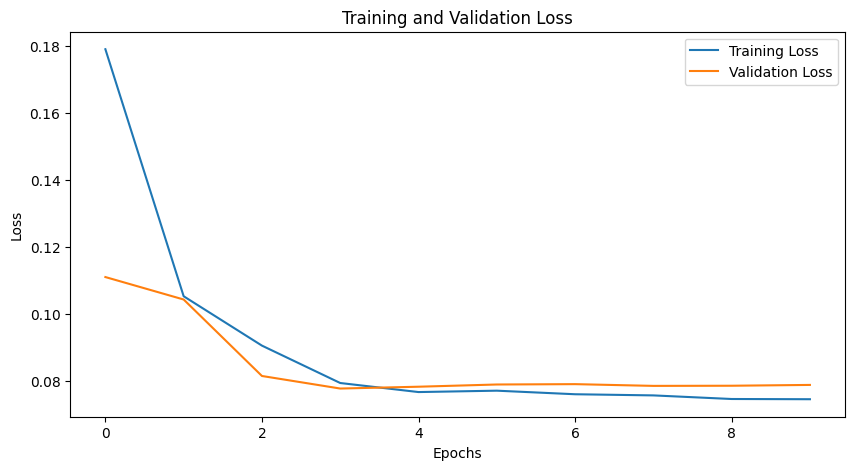

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
for batch in test_loader:
    print("Batch type:", type(batch))
    print("Number of elements in the batch:", len(batch))
    print("Type of first element in the batch:", type(batch[0]))
    if isinstance(batch[0], (tuple, list)):
        print("Type of first element of the first element in the batch:", type(batch[0][0]))
    break


Batch type: <class 'tuple'>
Number of elements in the batch: 2
Type of first element in the batch: <class 'tuple'>
Type of first element of the first element in the batch: <class 'torch.Tensor'>


In [29]:
model.eval()
predictions = []

with torch.no_grad():
    for i, (images, targets) in enumerate(test_loader):
        images = [img.to(device) for img in images]
        output = model(images)
        predictions.extend(output)

        if i == 4:
            break

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(image, target, prediction, threshold=0.7):
    pil_image = transforms.ToPILImage()(image.cpu()).convert("RGB")
    fig, ax = plt.subplots(1)
    ax.imshow(pil_image)

    for box in target['boxes']:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    for box, score in zip(prediction['boxes'], prediction['scores']):
        if score > threshold:
            x1, y1, x2, y2 = box.detach().cpu()
            print('x1')
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.show()

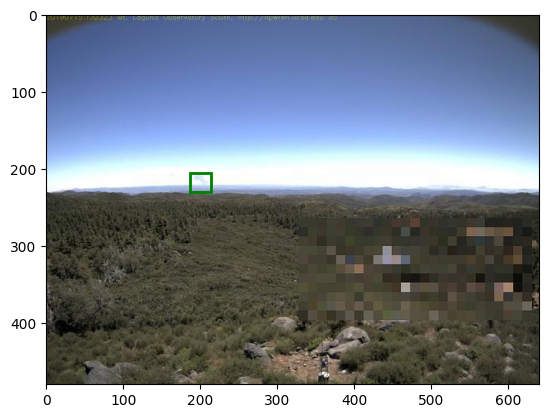

x1


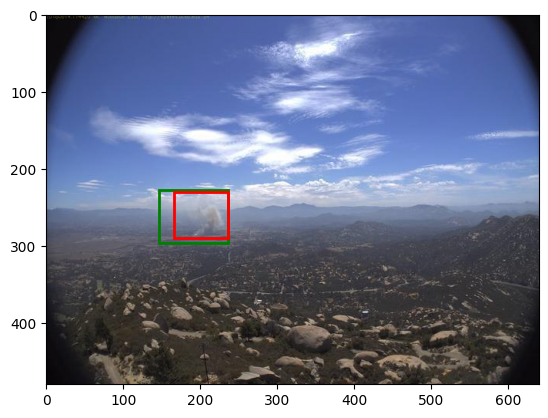

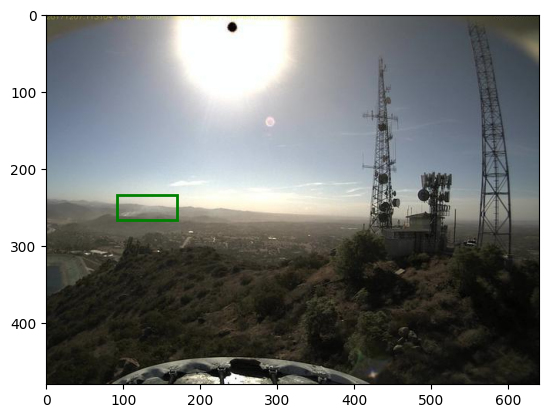

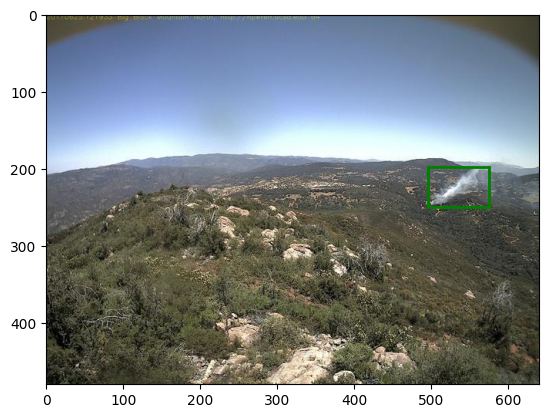

x1
x1


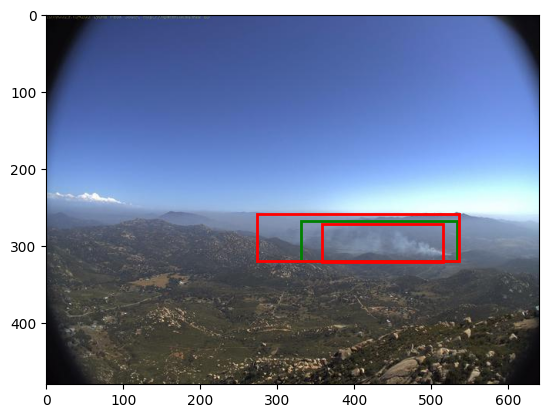

x1


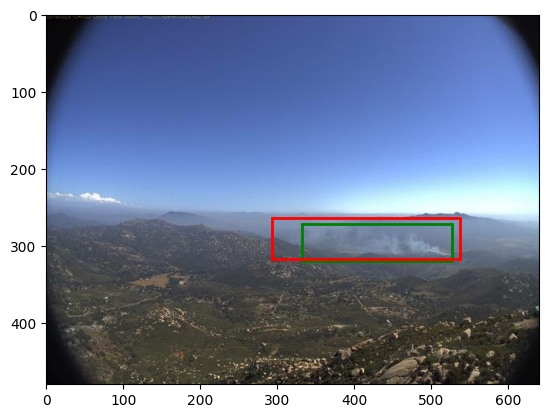

x1


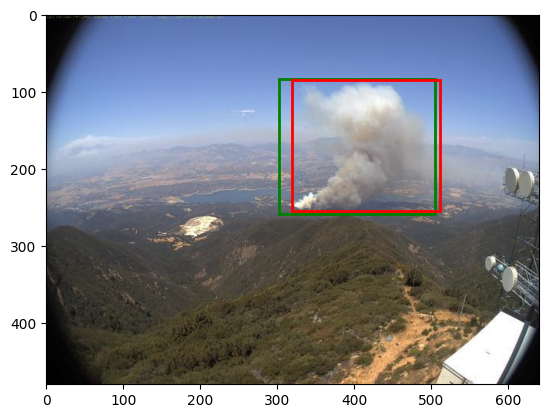

x1


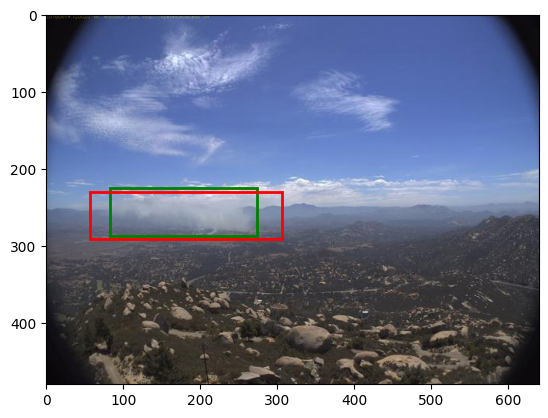

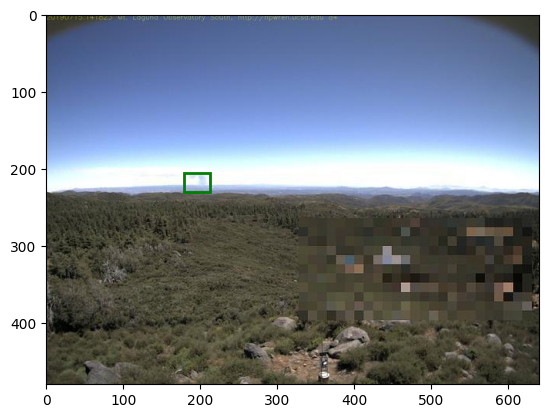

x1


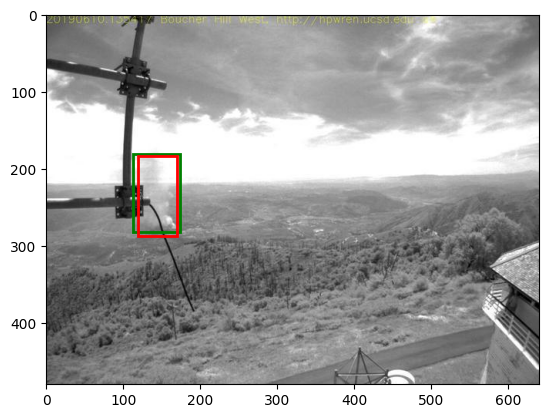

In [34]:
for i in range(10):
    test_image, test_target = test_dataset[i]
    prediction = predictions[i]
    plot_image_with_boxes(test_image, test_target, prediction)